In [1]:
import numpy as np
from scipy.special import gamma as gamma_f
from scipy.special import psi
from scipy.special import loggamma
import copy
import math
import matplotlib.pyplot as plt

In [2]:
x = np.loadtxt('GaussianMixtureData20130501.txt')

In [3]:
#データ数n
N = len(x)
#xの次元数D
D = len(x[0])
#分布数K
AllK = 11

In [4]:
def next_row(N,K,D,alpha,beta,x,u,nu,V):
    nextrow = np.ndarray((N,K),float)
    nu_d_sum = np.ndarray((K),float)
    nu_det_sum = np.ndarray((K,D),float)
    nu_det_sum_sum = np.ndarray((K),float)
    for k in range(K):
        nu_d_sum[k] = 0
        for d in range(D):
            nu_d_sum[k] += psi((nu[k] +1 - d)/2) 
    for n in range(N): 
        for k in range(K):
            nu_det_sum_sum[k] = 0
            for d1 in range(D):
                nu_det_sum[k][d1] = 0
                for d2 in range(D):
                    nu_det_sum[k][d1] += (x[n][d2] - u[k][d2]) * V[k][d2][d1]
            for d1 in range(D):
                nu_det_sum_sum[k] += nu_det_sum[k][d1] *  (x[n][d1] - u[k][d1])
            nextrow[n,k] = np.exp(psi(alpha[k]) + 1/2 * (nu_d_sum[k] + np.log(np.linalg.det(V[k])) - D/beta[k] - nu[k] * nu_det_sum_sum[k]))
      
    return nextrow

In [5]:
def next_gamma(K,row):
    nextgamma = np.ndarray((N,K),float)
    row_sum = np.ndarray((N),float)
    for n in range(N):
        row_sum[n] = 0
        for k in range(K):
            row_sum[n] += row[n,k]
        for k in range(K):
            nextgamma[n,k] = row[n,k] / row_sum[n]
    
    return nextgamma

In [6]:
def next_paras(K,gamma,alpha_0,beta_0,nu_0):
    nextalpha = np.ndarray((K),float)
    nextbeta = np.ndarray((K),float)
    nextnu = np.ndarray((K),float)
    eta = np.ndarray((K),float)
    for k in range(K):
        eta[k] = 0
        for n in range(N):
            eta[k] += gamma[n,k]
        nextalpha[k] = alpha_0 + eta[k]
        nextbeta[k] = beta_0 + eta[k]
        nextnu[k]  = nu_0  + eta[k]
        
    return nextalpha,nextbeta,nextnu

In [7]:
def next_u(K,gamma,x,beta_0,beta,u_0):
    u_sum = np.ndarray((D),float)
    nextu = np.ndarray((K,D),float)
    for k in range(K):
        for d in range(D):
            u_sum[d] = 0
            for n in range(N):
                u_sum[d] += gamma[n,k] * x[n,d]#結果保存したほうが早くなりそう
            nextu[k,d] = (beta_0 * u_0[d] + u_sum[d])/ beta[k]
    return nextu

In [8]:
def next_V(K,x,beta_0,u,u_0,V_0,gamma):
    nextV = np.ndarray((K,D,D),float)
    V1= np.ndarray((D,D),float)
    V2_sum = np.ndarray((D,D),float)
    for k in range(K):       
        for d1 in range(D):
            for d2 in range(D):
                V1[d1,d2] = beta_0 * (u[k,d1]-u_0[d1])* (u[k,d2]-u_0[d2])
                V2_sum[d1,d2] = 0 #第3項の和
                for n in range(N):
                    V2_sum[d1,d2] += gamma[n,k] * (x[n,d1]-u[k,d1])* (x[n,d2]-u[k,d2])
        nextV[k] = np.linalg.inv(np.linalg.inv(V_0) + V1 + V2_sum)   
    return nextV

In [9]:
def multi_d_loggamma(D,a):
    loggamma_multi = 0 #loggamma関数の和をとる初期値
    for d in range(D):
        loggamma_multi += loggamma(a - (d)/2)
        
    return (D*(D-1)/4)*np.log(np.pi)+loggamma_multi

In [10]:
def select_mixed_number(K,N,D,gamma,alpha,alpha_0,beta,beta_0,nu,nu_0,V_0,V):
    mixed_1 = loggamma(K*alpha_0 + N)- loggamma(K*alpha_0) #第一項
    #print(mixed_1)
    mixed_2 = 0 #第二項
    for n in range(N):
        for k in range(K):
            if gamma[n,k] == 0: continue
            mixed_2 += gamma[n,k] * np.log(gamma[n,k])
    #print(mixed_2)
    mixed_3 = 0 #第3項
    for k in range(K):
        mixed_3_1 =  loggamma(alpha_0)+multi_d_loggamma(D,nu_0)-(loggamma(alpha[k])+multi_d_loggamma(D,nu[k]))
        mixed_3_2 = (1/2) * (nu_0 * np.log(np.linalg.det(V_0))) - nu[k] * np.log(np.linalg.det(V[k])) + D * (np.log(beta[k]-np.log(beta_0)))
        mixed_3 += mixed_3_1 + mixed_3_2
    #print(mixed_3)
        
    return mixed_1 + mixed_2 + mixed_3
        

In [11]:
def learn_param(K):
    #宣言（必要ないかもだけど一応）
    row = np.ndarray((N,K),float)
    alpha = np.ndarray(K,float)
    beta = np.ndarray(K,float)
    nu = np.ndarray(K,float)
    gamma = np.ndarray((N,K),float)
    before_gamma = np.ndarray((N,K),float)
    u = np.ndarray((K,D),float)
    V = np.ndarray((K,D,D),float)
    #初期値と初期化
    alpha_0 = D + 1
    beta_0 = D + 1
    nu_0 = D + 1
    u_0 = np.zeros(D)
    for n in range(N):
        u_0 += x[n]
    u_0 = u_0 / N
    V_0_cal = np.zeros((D,D)) #V_0計算用
    for n in range(N):
        for d1 in range(D):
            for d2 in range(D):
                V_0_cal[d1,d2] += (x[n,d1]- u_0[d1])*(x[n,d2]- u_0[d2])
    V_0 = np.linalg.inv(nu_0 * (1/N) * V_0_cal)
    
    u = np.random.multivariate_normal(u_0, np.linalg.inv(beta_0*nu_0*V_0), K)
    for k in range(K):
        alpha[k] = alpha_0
        beta[k] = beta_0
        nu[k] = nu_0
        V[k] = copy.deepcopy(V_0)
        #収束判定用
        before_gamma[k] = -float('inf')
    while(1):
        row = next_row(N,K,D,alpha,beta,x,u,nu,V)
        gamma = next_gamma(K,row)
        alpha,beta,nu = next_paras(K,gamma,alpha_0,beta_0,nu_0)
        u = next_u(K,gamma,x,beta_0,beta,u_0)
        V = next_V(K,x,beta_0,u,u_0,V_0,gamma)
        for n in range(N):
            for k in range(K):
                flag = 0
                if(abs(gamma[n][k] - before_gamma[n][k]) > 1e-3):
                    flag = 1
                    break
            if(flag == 1):
                break
        if(flag == 0):
            break
        else:
            before_gamma = gamma
        
    return  gamma,alpha,alpha_0,beta,beta_0,nu,nu_0,V_0,V,u

In [12]:
def posterior_ave(K,alpha,u,nu,V): #事後平均解計算
    post_ave_w = np.ndarray((K),float)
    post_ave_mu = np.ndarray((K,D),float)
    post_ave_sigma = np.ndarray((K,D,D),float)
    alpha_sum = 0
    for k in range(K):
        alpha_sum += alpha[k] #1との内積計算 = 和
    for k in range(K):
        post_ave_w[k] = alpha[k]/alpha_sum
        post_ave_mu[k] = u[k]
        post_ave_sigma[k] = nu[k] * V[k]
    return post_ave_w,post_ave_mu,post_ave_sigma

In [13]:
#グラフ描画
#参考資料
# https://qiita.com/shinmura0/items/901593e3d8a5238f8ae4
# http://civilyarou.web.fc2.com/WANtaroHP_html5_win/f90_STAT/dir_SREG/TeX_ellipse.pdf
def ellipse_drow(mu,sigma):
    curve_c = np.zeros((2,201))
    
    C_c = sigma[0][1]/((np.sqrt(sigma[0][0])*np.sqrt(sigma[1][1])))
    p = 1- np.exp(-1/2)
    for i in range(201):
        r = (-2*(1-C_c**2)*np.log(1-p)/(1-2*C_c*np.sin(i*2*np.pi/200)*np.cos(i*2*np.pi/200)))**0.5
        curve_c[0,i] = mu[0] + np.sqrt(sigma[0][0])*r*np.cos(i*2*np.pi/200)
        curve_c[1,i] = mu[1] + np.sqrt(sigma[1][1])*r*np.sin(i*2*np.pi/200)
    return curve_c

In [14]:
#グラフ描画
def glaphplot(x,mu,sigma,K):
    fig,ax = plt.subplots(figsize=(5,5))
    ax.plot(x[:,0],x[:,1],'.')
    for k in range(K):
        curve_c = ellipse_drow(mu[k],np.linalg.inv(sigma[k]))
        ax.plot(curve_c[0],curve_c[1],'.',color = 'red',markersize=0.8)
    plt.savefig('tpip10GMM.png')
    plt.show()

状態数推定1~10
[21121.70731284 19449.61044004 19031.21874315 19074.62466146
 19117.0947033  19159.06849969 19200.54807148 19241.75499162
 19282.25517915 19322.59720226]
最適な状態数は: 3
重みw
 [0.26744884 0.26842724 0.46412393]
平均μ
 [[-38.39189631  17.11648285]
 [  1.15824831  -0.65686714]
 [ 39.79711098  -0.13872738]]
逆分散共分散
 [[[ 0.00670816  0.00018879]
  [ 0.00018879  0.0010741 ]]

 [[ 0.00103425 -0.00014024]
  [-0.00014024  0.00931572]]

 [[ 0.01110114 -0.00136437]
  [-0.00136437  0.00080731]]]


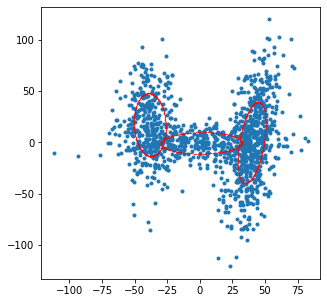

In [17]:
if __name__ == "__main__":
    K_array = np.ndarray(AllK-1) #Kの推定数を表示するやつ
    for K in range(1,AllK):  
        gamma,alpha,alpha_0,beta,beta_0,nu,nu_0,V_0,V,_ = learn_param(K)
        K_array[K-1] = select_mixed_number(K,N,D,gamma,alpha,alpha_0,beta,beta_0,nu,nu_0,V_0,V)
    print('状態数推定1~10')
    print(K_array)
    #K_arrayの最大値から最大値をもらう
    trueK = np.argmin(K_array) + 1
    print('最適な状態数は:',trueK)
    #事後平均解を得る
    _,alpha,_,_,_,nu,_,_,V,u = learn_param(trueK)
    w,mu,sigma = posterior_ave(trueK,alpha,u,nu,V)
    print('重みw\n',w)
    print('平均μ\n',mu)
    print('逆分散共分散行列Σ\n',sigma)
    glaphplot(x,mu,sigma,trueK)